# Experiment with gpt-3.5-turbo

Research question - **How do different DSPy optimizers impact the accuracy of product sentiment polarity classification compared to a baseline model without optimization?**

**H0** - _There is no significant difference in accuracy of sentiment predictions between a simple LLM call with a function call and models using DSPy optimizers._

**H1** - _There is a significant improvement in accuracy of sentiment prediction with the use of DSPy optimizers compared to a simple LLM call with a function call._


## 0. Dataset
The experiment will employ an artificially created dataset of response and lable pairs. 

In [2]:
import pandas as pd
import dotenv

dotenv.load_dotenv()

df = pd.read_csv("./data/product-sentiment-dataset.csv")
df.head()

,Unnamed: 0,question,sentiment,answer
0,0,What are the main differences between the iPho...,very_positive,The iPhone 15 Pro stands out with its A17 Bion...
1,1,How does the battery life of the iPhone 15 Pro...,very_positive,The iPhone 15 Pro features significant improve...
2,2,What new features does the A17 Pro chipset bri...,very_positive,The A17 Pro chipset on the iPhone 15 Pro offer...
3,3,Is the iPhone 15 Pro’s camera better than the ...,very_positive,"Absolutely, the iPhone 15 Pro’s camera is a si..."
4,4,How durable is the iPhone 15 Pro’s titanium de...,very_positive,The iPhone 15 Pro’s titanium design is the mos...


In [3]:
import dspy

dataset = []
sentiments = []
for _, row in df.iterrows():
    dataset.append(
        dspy.Example(output=row.answer, sentiment=row.sentiment).with_inputs("output")
    )
    sentiments.append(row.sentiment)



We will prepare 3 `train_test_splits` as different optimizers are made for different amount of training data. Read more - [DSPy Documentation](https://dspy-docs.vercel.app/docs/building-blocks/optimizers#which-optimizer-should-i-use)
We are making sure that each dataset is balanced across each category of the sentiments by stratifying it.

In [4]:
from sklearn.model_selection import train_test_split

trainset, devset = train_test_split(dataset, test_size=0.2, stratify=sentiments, random_state=759)

trainset_10, devset_10 = train_test_split(dataset, train_size=10, test_size=0.2, stratify=sentiments, random_state=759)

trainset_50, devset_50 = train_test_split(dataset, train_size=50, test_size=0.2, stratify=sentiments, random_state=759)

trainset_300, devset_300 = train_test_split(dataset, train_size=300, test_size=0.2, stratify=sentiments, random_state=759)

print("trainset len", len(trainset))
print("devset len", len(devset))

print("trainset_10 len", len(trainset_10))
print("trainset_50 len", len(trainset_50))
print(trainset[0:10])
print(trainset_10)
print(trainset_50[0:10])

vp, sp, sn, vn, s = 0, 0, 0, 0, 0
for i in trainset_300:
    if i.sentiment == "very_positive":
        vp += 1
    if i.sentiment == "subtly_positive":
        sp += 1
    if i.sentiment == "subtly_negative":
        sn += 1
    if i.sentiment == "very_negative":
        vn += 1
    if i.sentiment == "skipped":
        s += 1

print(vp, sp, sn, vn, s)


trainset len 398
devset len 100
trainset_10 len 10
trainset_50 len 50
[Example({'output': "The A17 Pro chipset in the iPhone 15 Pro brings marginally better performance and slightly improved power efficiency, but honestly, these upgrades won't drastically change your experience. It's just another marketing tactic to justify a hefty price tag. Apple really needs to innovate beyond incremental improvements if they want to stay ahead.", 'sentiment': 'very_negative'}) (input_keys={'output'}), Example({'output': "Yes, the iPhone 15 supports USB-C charging! This highly anticipated upgrade brings faster charging speeds and enhanced data transfer capabilities. It's a significant improvement that aligns with global standards, making the iPhone 15 a top-tier choice for those seeking cutting-edge technology and convenience in a smartphone. You’ll love the seamless experience it offers!", 'sentiment': 'very_positive'}) (input_keys={'output'}), Example({'output': 'The Google Pixel 8 offers solid ba

## 1. Classify the dataset with the help of gpt-3.5-turbo with a function call
Here we will create a gpt-3.5-turbo instance with DSPy library.
We will also make a little adjustment to the original DSPy codebase to support the function calls.



In [11]:
import json
from typing import Any
import re
import dsp.modules.gpt3 as gpt3

model = "gpt-3.5-turbo"

tools_args = {
    "tools":[
        {
            "type": "function",
            "function": {
                "name": "sentiment",
                "parameters": {
                    "type": "object",
                    "properties": {
                        # "positive_points": {
                        #     "type": "string",
                        #     "description": "positive points mentioned in the output, empty string if none",
                        # },
                        # "negative_points": {
                        #     "type": "string",
                        #     "description": "negative points mentioned in the output, empty string if none",
                        # },
                        "reasoning": {
                            "type": "string",
                            "description": "reason about the output tone and intensity before giving the final verdict on the sentiment, \
                                notice that there are no neutral options, you have to decide if the output tends more towards negative, positive, or skipped if not a product output"
                        },
                        "sentiment": {
                            "type": "string",
                            "enum": [
                                "very_positive",
                                "subtly_positive",
                                "subtly_negative",
                                "very_negative",
                                "skipped"
                            ],
                            "description": "the sentiment of output following one of the 4 options or skipped if not a product",
                        },
                    },
                    "required": ["sentiment", "reasoning"],
                },
                "description": "use this function if you need to give your verdict on the sentiment",
            },
        },
    ],
    "temperature": 0,
    # tool_choice="auto",
    "tool_choice": {"type": "function", "function": {"name": "sentiment"}},
}

# Set up the LM
llm = dspy.OpenAI(
    model=model,
    max_tokens=2048,
    **tools_args,
)

gpt4 = dspy.OpenAI(
    model="gpt-4o",
    max_tokens=2048,
    **tools_args,
)

last_program = None

program_for_prompt = {}

def _get_choice_text(self, choice: dict[str, Any]) -> str:
    prompt: str = self.history[-1]["prompt"]
    if self.model_type == "chat":
        message = choice["message"]
        if content := message["content"]:
            return content
        elif tool_calls := message.get("tool_calls", None):
            arguments = json.loads(tool_calls[0]["function"]["arguments"])
            sentiment_prefix = last_program.predict.signature.fields['sentiment'].json_schema_extra['prefix']

            if last_program and prompt.endswith(sentiment_prefix):
                return arguments["sentiment"]
            else:
                return arguments["reasoning"]
    return choice["text"]


cached_request_map = {}

if not hasattr(gpt3, "_original_chat_request"):
    gpt3._original_chat_request = gpt3.chat_request

def _chat_request(**kwargs):
    llm_request = json.loads(kwargs['stringify_request'])
    model = llm_request["model"]
    prompt = llm_request['messages'][-1]['content']

    if last_program:
        program_for_prompt[prompt] = last_program

        reasoning_prefix = last_program.predict.signature.fields['reasoning'].json_schema_extra['prefix']
        sentiment_prefix = last_program.predict.signature.fields['sentiment'].json_schema_extra['prefix']
        
        if prompt.endswith(reasoning_prefix) or prompt.endswith(sentiment_prefix):
            base_prompt = re.match(r"[\s\S]*" + re.escape(reasoning_prefix), prompt)[0]
            base_prompt = model + base_prompt
            if base_prompt not in cached_request_map:
                cached_request_map[base_prompt] = gpt3._original_chat_request(**kwargs)
            return cached_request_map[base_prompt]
        else:
            return gpt3._original_chat_request(**kwargs)
    else:
        return gpt3._original_chat_request(**kwargs)


llm._get_choice_text = _get_choice_text.__get__(llm)
gpt4._get_choice_text = _get_choice_text.__get__(gpt4)
gpt3.chat_request = _chat_request


dspy.settings.configure(lm=llm)

In [6]:
from typing import Literal

from pydantic import BaseModel, Field


class Sentiment(BaseModel):
    sentiment: Literal["very_positive", "subtly_positive", "subtly_negative", "very_negative", "skipped"] = Field(description="The sentiment of output following one of the 4 options or skipped if not a product review")

class ProductSentimentPolaritySignature(dspy.Signature):
    """Classify the sentiment of the output among very_positive, subtly_positive, subtly_negative, very_negative or skipped if not a product review"""

    output = dspy.InputField(desc="Output of the LLM talking about the product")
    reasoning = dspy.OutputField(desc="Reason about the output tone and intensity before giving the final verdict on the sentiment, \
                                notice that there are no neutral options, you have to decide if the output tends more towards negative, positive, or skipped if not a product output")
    # positive_points : str = dspy.OutputField(desc="Positive points mentioned on the output.")
    # negative_points : str = dspy.OutputField(desc="Negative points mentioned on the output.")
    sentiment : Sentiment = dspy.OutputField()

class ProductSentimentPolarity(dspy.Module):
    def __init__(self):
        super().__init__()
        # self.predict = dspy.Predict(ProductSentimentPolaritySignature)
        self.predict = dspy.Predict("output -> reasoning, sentiment")

    def forward(self, output):
        global last_program
        last_program = self
        return self.predict(output=output)

dev_example = devset[0]
print(dev_example)

pred = ProductSentimentPolarity()(output=dev_example.output)
pred

Example({'output': "The Xiaomi 14 Pro offers storage options up to 1TB. While that's quite ample for most users, it's worth noting that other flagship models also offer similar capacities. If you're looking for substantial storage, the 14 Pro is competitive, but it doesn't stand out drastically in today's market.", 'sentiment': 'subtly_negative'}) (input_keys={'output'})


Prediction(
    reasoning='The output provides a balanced comparison of the storage capacity of the Xiaomi 14 Pro with other flagship models, highlighting its competitiveness but lack of standout features in the market.',
    sentiment='subtly_negative'
)

In [7]:
llm.inspect_history()




Given the fields `output`, produce the fields `reasoning`, `sentiment`.

---

Follow the following format.

Output: ${output}
Reasoning: ${reasoning}
Sentiment: ${sentiment}

---

Output: The Xiaomi 14 Pro offers storage options up to 1TB. While that's quite ample for most users, it's worth noting that other flagship models also offer similar capacities. If you're looking for substantial storage, the 14 Pro is competitive, but it doesn't stand out drastically in today's market.
Reasoning: The output provides a balanced comparison of the storage capacity of the Xiaomi 14 Pro with other flagship models, highlighting its competitiveness but lack of standout features in the market.
Sentiment: subtly_negative





"\n\n\nGiven the fields `output`, produce the fields `reasoning`, `sentiment`.\n\n---\n\nFollow the following format.\n\nOutput: ${output}\nReasoning: ${reasoning}\nSentiment: ${sentiment}\n\n---\n\nOutput: The Xiaomi 14 Pro offers storage options up to 1TB. While that's quite ample for most users, it's worth noting that other flagship models also offer similar capacities. If you're looking for substantial storage, the 14 Pro is competitive, but it doesn't stand out drastically in today's market.\nReasoning: The output provides a balanced comparison of the storage capacity of the Xiaomi 14 Pro with other flagship models, highlighting its competitiveness but lack of standout features in the market.\nSentiment:\x1b subtly_negative\x1b\n\n\n"

Here we will define our metric that we will reuse across all optimizations. It is a simple `exact_match` evaluation, as far as we have a classification task with 4 well defined categories.

In [8]:
def sentiment_matches(example, pred, trace=None):
    return example.sentiment == pred.sentiment

scores = []

To exclude statistical luck - we run 10 evaluations with to measure the baseline accuracy of gpt-3.5-turbo without any optimizations.

In [9]:
from dspy.evaluate import Evaluate

for i in range(0, 10):
    evaluation = Evaluate(
        devset=devset, metric=sentiment_matches, num_threads=16, display_progress=True
    )
    score = evaluation(ProductSentimentPolarity())  # type: ignore
    scores.append(score)

import numpy as np

print("average score", sum(scores) / len(scores))
print("median score", np.median(scores))
print("min score", min(scores))
print("max score", max(scores))
print("variance", np.var(scores))

Average Metric: 51 / 100  (51.0): 100%|██████████| 100/100 [00:00<00:00, 3581.14it/s]

average score 51.0
median score 51.0
min score 51.0
max score 51.0
variance 0.0


**Baseline Accuracy** - 43.827%

# 2. Classify with the help of DSPy optimizers
Here we will create several optimizers that will be used to optimize the LLM. We later will evaluate each of them and compare the results with the baseline.
We will use a dashboard from LangWatch to observe the optimizations.

In [1]:
# %cd /Users/zhenyabudnyk/DevProjects/langwatch-saas/langwatch/python-sdk/
# %pip install .

import langwatch

langwatch.endpoint = "https://app.langwatch.ai"
langwatch.login(relogin=True)

Please go to https://app.langwatch.ai/authorize to get your API key
LangWatch API key set


### 2.1 BootstrapFewShot
BootstrapFewShot optimizer is simply selecting several few-shot demonstrations


In [168]:
from dspy.teleprompt import BootstrapFewShot

optimizer = BootstrapFewShot(
    metric=sentiment_matches,
    max_bootstrapped_demos=8,
    max_labeled_demos=8,
    teacher_settings=dict(lm=gpt4)
)

langwatch.dspy.init(experiment="product_sentiment_polarity_openai_experiment", optimizer=optimizer)

optimized_evaluator = optimizer.compile(ProductSentimentPolarity(), trainset=trainset_10)


[LangWatch] Experiment initialized, run_id: orthodox-refreshing-tarsier
[LangWatch] Open https://app.langwatch.ai/inbox-narrator/experiments/product_sentiment_polarity_openai_experiment?runIds=orthodox-refreshing-tarsier to track your DSPy training session live



100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


In [157]:
from dspy.evaluate import Evaluate

evaluate_dev = Evaluate(devset=devset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)

dev_score = evaluate_dev(optimized_evaluator)
dev_score

Average Metric: 68 / 100  (68.0): 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


68.0

**Accuracy BootstrapFewShot** - 60.49%

## 2.2 BootstrapFewShotWithRandomSearch 

In [13]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
optimizer = BootstrapFewShotWithRandomSearch(
    metric=sentiment_matches,
    max_bootstrapped_demos=8,
    max_labeled_demos=8,
    max_rounds=1,
    num_candidate_programs=8,
    teacher_settings=dict(lm=gpt4)
)

langwatch.dspy.init(experiment="product_sentiment_polarity_openai_experiment", optimizer=optimizer)

optimized_evaluator = optimizer.compile(ProductSentimentPolarity(), trainset=trainset_50)


[LangWatch] Experiment initialized, run_id: adept-alpaca-of-wind
[LangWatch] Open https://app.langwatch.ai/curriculum-vitai-3r_1j8/experiments/product_sentiment_polarity_openai_experiment?runIds=adept-alpaca-of-wind to track your DSPy training session live



Average Metric: 33 / 50  (66.0): 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


In [15]:
from dspy.evaluate import Evaluate

evaluate_dev = Evaluate(devset=devset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)

dev_score = evaluate_dev(optimized_evaluator)
dev_score

Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 5267.04it/s]


71.0

**Accuracy BootstrapFewShotWithRandomSearch** - 59.26%

## 2.3 BootstrapFewShotWithOptuna

In [60]:
from dspy.teleprompt import BootstrapFewShotWithOptuna

optimizer = BootstrapFewShotWithOptuna(
    metric=sentiment_matches,
    max_bootstrapped_demos=8,
    max_labeled_demos=8,
    max_rounds=1,
    num_candidate_programs=8,
)

# langwatch.dspy.init(experiment="product_sentiment_polarity_openai_experiment", optimizer=optimizer)

optimized_evaluator = optimizer.compile(ProductSentimentPolarity(), trainset=trainset_50, max_demos=8)

Going to sample between 1 and 8 traces per predictor.
Will attempt to train 8 candidate sets.


 40%|████      | 20/50 [00:12<00:19,  1.57it/s]
[I 2024-06-04 16:36:31,239] A new study created in memory with name: no-name-b9d4b603-4f64-4982-9386-1278a02585e5
Average Metric: 27 / 50  (54.0): 100%|██████████| 50/50 [00:05<00:00,  9.44it/s]
[I 2024-06-04 16:36:36,563] Trial 0 finished with value: 54.0 and parameters: {'demo_index_for_predict': 5}. Best is trial 0 with value: 54.0.
Average Metric: 21 / 50  (42.0): 100%|██████████| 50/50 [00:05<00:00,  9.39it/s]
[I 2024-06-04 16:36:41,913] Trial 1 finished with value: 42.0 and parameters: {'demo_index_for_predict': 2}. Best is trial 0 with value: 54.0.
Average Metric: 27 / 50  (54.0): 100%|██████████| 50/50 [00:00<00:00, 3389.12it/s]
[I 2024-06-04 16:36:41,943] Trial 2 finished with value: 54.0 and parameters: {'demo_index_for_predict': 5}. Best is trial 0 with value: 54.0.
Average Metric: 25 / 50  (50.0): 100%|██████████| 50/50 [00:05<00:00,  9.36it/s]
[I 2024-06-04 16:36:47,301] Trial 3 finished with value: 50.0 and parameters: {'dem

Best score: 58.0
Best program: predict = Predict(ProductSentimentPolaritySignature(output -> sentiment
    instructions='Classify the sentiment of the output among very_positive, subtly_positive, subtly_negative, very_negative or skipped if not a product review'
    output = Field(annotation=str required=True json_schema_extra={'desc': 'Output of the LLM talking about the product', '__dspy_field_type': 'input', 'prefix': 'Output:'})
    sentiment = Field(annotation=Sentiment required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Sentiment:', 'desc': '${sentiment}'})
))


In [14]:
from dspy.evaluate import Evaluate

evaluate_dev = Evaluate(devset=devset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)

dev_score = evaluate_dev(optimized_evaluator)
dev_score

Average Metric: 58 / 81  (71.6): 100%|██████████| 81/81 [00:11<00:00,  6.87it/s]


71.6

**Accuracy BootstrapFewShotWithOptuna** - 71.6%

## 2.4 KNNFewShot

In [15]:
from dspy.predict import KNN
from dspy.teleprompt import KNNFewShot

optimizer = KNNFewShot(KNN, k=10, trainset=trainset_50)


# langwatch.dspy.init(experiment="product_sentiment_polarity_openai_experiment", optimizer=optimizer)

optimized_evaluator = optimizer.compile(ProductSentimentPolarity(), trainset=trainset_50)

/Users/zhenyabudnyk/DevProjects/langwatch-saas/langevals/notebooks/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [16]:
from dspy.evaluate import Evaluate

evaluate_dev = Evaluate(devset=devset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)

dev_score = evaluate_dev(optimized_evaluator)
dev_score

  0%|          | 0/81 [00:00<?, ?it/s]

























 40%|████      | 4/10 [00:02<00:03,  1.83it/s]

 40%|████      | 4/10 [00:02<00:03,  1.67it/s]



Average Metric: 2 / 4  (50.0):   4%|▎         | 3/81 [00:03<01:00,  1.29it/s]



















 40%|████      | 4/10 [00:02<00:03,  1.87it/s]

 40%|████      | 4/10 [00:02<00:03,  1.84it/s]


Average Metric: 3 / 6  (50.0):   6%|▌         | 5/81 [00:05<01:18,  1.03s/it]

Average Metric: 3 / 7  (42.9):   9%|▊         | 7/81 [00:06<00:52,  1.41it/s]









 40%|████      | 4/10 [00:02<00:03,  1.84it/s]



 40%|████      | 4/10 [00:04<00:06,  1.15s/it]



 40%|████      | 4/10 [00:02<00:04,  1.41it/s]


Average Metric: 5 / 10  (50.0):  11%|█         | 9/81 [00:09<01:10,  1.01it/s]



Average Metric: 5 / 11  (45.5):  14%|█▎        | 11/81 [00:10<00:52,  1.34it/s]













 40%|████      | 4/10 [00:02<00:04,  1.36it/s]


Average Metric: 7 / 13  (53.8):  15%|█▍        | 12/81 [00:11<01:10,  1.02s/it]







 40%|████      | 4

50.62

**Accuracy KNNFewShot** - 50.62%

## 2.5 COPRO

In [17]:
from dspy.teleprompt import COPRO

optimizer = COPRO(depth=5, trainset=trainset, metric=sentiment_matches, track_stats=True)
kwargs = dict(num_threads=64, display_progress=True, display_table=0)


langwatch.dspy.init(experiment="product_sentiment_polarity_openai_experiment", optimizer=optimizer)

optimized_evaluator = optimizer.compile(ProductSentimentPolarity(), trainset=trainset_50,  eval_kwargs=kwargs)


[LangWatch] Experiment initialized, run_id: efficient-paper-turkey
[LangWatch] Open http://localhost:3000/experiment-dspy-iOg5EE/experiments/product_sentiment_polarity_openai_experiment?runIds=efficient-paper-turkey to track your DSPy training session live



Average Metric: 13 / 50  (26.0): 100%|██████████| 50/50 [00:00<00:00, 77.02it/s]


In [18]:
from dspy.evaluate import Evaluate

evaluate_dev = Evaluate(devset=devset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)

dev_score = evaluate_dev(optimized_evaluator)
dev_score

  0%|          | 0/81 [00:00<?, ?it/s]

Average Metric: 35 / 81  (43.2): 100%|██████████| 81/81 [00:10<00:00,  7.40it/s]


43.21

**Accuracy COPRO** - 43.21%

## 2.6 MIPRO

In [15]:
from dspy.teleprompt import MIPRO

gpt4_prompt_model = dspy.OpenAI(
    model="gpt-4o",
    max_tokens=2048,
)

optimizer = MIPRO(prompt_model=gpt4_prompt_model, task_model=llm, metric=sentiment_matches, num_candidates=10, teacher_settings=dict(lm=gpt4))
kwargs = dict(num_threads=16, display_progress=True, display_table=0)

langwatch.dspy.init(experiment="product_sentiment_polarity_openai_experiment", optimizer=optimizer)

optimized_evaluator = optimizer.compile(ProductSentimentPolarity(), trainset=trainset_300, max_bootstrapped_demos=8, num_trials=50, max_labeled_demos=8, view_examples=False, eval_kwargs=kwargs)


[LangWatch] Experiment initialized, run_id: cunning-private-pronghorn
[LangWatch] Open https://app.langwatch.ai/inbox-narrator/experiments/product_sentiment_polarity_openai_experiment?runIds=cunning-private-pronghorn to track your DSPy training session live


Please be advised that based on the parameters you have set, the maximum number of LM calls is projected as follows:

- Task Model: 300 examples in dev set * 50 trials * # of LM calls in your program = (15000 * # of LM calls in your program) task model calls
- Prompt Model: # data summarizer calls (max 10) + 10 * 1 lm calls in program = 20 prompt model calls

Estimated Cost Calculation:

Total Cost = (Number of calls to task model * (Avg Input Token Length per Call * Task Model Price per Input Token + Avg Output Token Length per Call * Task Model Price per Output Token) 
            + (Number of calls to prompt model * (Avg Input Token Length per Call * Task Prompt Price per Input Token + Avg Output Token Length per Call * Prompt

  4%|▎         | 11/300 [00:00<00:00, 2614.75it/s]
[I 2024-06-05 15:17:42,230] A new study created in memory with name: no-name-98ffa600-3939-4e95-80f2-e54fa20ed3de


Starting trial #0


Average Metric: 65 / 100  (65.0): 100%|██████████| 100/100 [00:00<00:00, 4503.85it/s]
[I 2024-06-05 15:17:44,087] Trial 0 finished with value: 71.33333333333333 and parameters: {'5506468944_predictor_instruction': 1, '5506468944_predictor_demos': 2}. Best is trial 0 with value: 71.33333333333333.


Starting trial #1


Average Metric: 53 / 100  (53.0): 100%|██████████| 100/100 [00:00<00:00, 1267.39it/s]
[I 2024-06-05 15:17:45,438] Trial 1 finished with value: 63.333333333333336 and parameters: {'5506468944_predictor_instruction': 6, '5506468944_predictor_demos': 6}. Best is trial 0 with value: 71.33333333333333.


Starting trial #2


Average Metric: 68 / 100  (68.0): 100%|██████████| 100/100 [00:00<00:00, 5339.05it/s]
[I 2024-06-05 15:17:46,881] Trial 2 finished with value: 69.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 3}. Best is trial 0 with value: 71.33333333333333.


Starting trial #3


Average Metric: 68 / 100  (68.0): 100%|██████████| 100/100 [00:00<00:00, 4021.89it/s]
[I 2024-06-05 15:17:49,108] Trial 3 finished with value: 69.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 3}. Best is trial 0 with value: 71.33333333333333.


Starting trial #4


Average Metric: 66 / 100  (66.0): 100%|██████████| 100/100 [00:00<00:00, 5329.35it/s]
[I 2024-06-05 15:17:50,669] Trial 4 finished with value: 69.33333333333333 and parameters: {'5506468944_predictor_instruction': 4, '5506468944_predictor_demos': 3}. Best is trial 0 with value: 71.33333333333333.


Starting trial #5


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 4659.56it/s]
[I 2024-06-05 15:17:51,902] Trial 5 finished with value: 74.33333333333333 and parameters: {'5506468944_predictor_instruction': 6, '5506468944_predictor_demos': 8}. Best is trial 5 with value: 74.33333333333333.


Starting trial #6


Average Metric: 68 / 100  (68.0): 100%|██████████| 100/100 [00:00<00:00, 2095.65it/s]
[I 2024-06-05 15:17:52,828] Trial 6 finished with value: 75.33333333333333 and parameters: {'5506468944_predictor_instruction': 7, '5506468944_predictor_demos': 4}. Best is trial 6 with value: 75.33333333333333.


Starting trial #7


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 4372.76it/s]
[I 2024-06-05 15:17:55,106] Trial 7 finished with value: 74.33333333333333 and parameters: {'5506468944_predictor_instruction': 6, '5506468944_predictor_demos': 8}. Best is trial 6 with value: 75.33333333333333.


Starting trial #8


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 2804.64it/s]
[I 2024-06-05 15:17:56,546] Trial 8 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #9


Average Metric: 65 / 100  (65.0): 100%|██████████| 100/100 [00:00<00:00, 6008.95it/s]
[I 2024-06-05 15:17:57,255] Trial 9 pruned. 


Trial pruned.
Starting trial #10


Average Metric: 41 / 100  (41.0): 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]
[I 2024-06-05 15:18:16,900] Trial 10 pruned. 


Trial pruned.
Starting trial #11


Average Metric: 68 / 100  (68.0): 100%|██████████| 100/100 [00:00<00:00, 2273.30it/s]
[I 2024-06-05 15:18:17,569] Trial 11 finished with value: 75.33333333333333 and parameters: {'5506468944_predictor_instruction': 7, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #12


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 5754.69it/s]
[I 2024-06-05 15:18:19,593] Trial 12 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #13


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 4248.77it/s]
[I 2024-06-05 15:18:21,511] Trial 13 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #14


Average Metric: 68 / 100  (68.0): 100%|██████████| 100/100 [00:21<00:00,  4.57it/s]
[I 2024-06-05 15:18:44,211] Trial 14 pruned. 


Trial pruned.
Starting trial #15


Average Metric: 72 / 100  (72.0): 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]
[I 2024-06-05 15:19:07,662] Trial 15 pruned. 


Trial pruned.
Starting trial #16


Average Metric: 62 / 100  (62.0): 100%|██████████| 100/100 [00:11<00:00,  8.93it/s]
[I 2024-06-05 15:19:19,481] Trial 16 pruned. 


Trial pruned.
Starting trial #17


Average Metric: 72 / 100  (72.0): 100%|██████████| 100/100 [00:11<00:00,  8.93it/s]
[I 2024-06-05 15:19:31,087] Trial 17 pruned. 


Trial pruned.
Starting trial #18


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 2166.85it/s]
[I 2024-06-05 15:19:32,017] Trial 18 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #19


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 5321.44it/s]
[I 2024-06-05 15:19:33,166] Trial 19 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #20


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]
[I 2024-06-05 15:19:55,998] Trial 20 pruned. 


Trial pruned.
Starting trial #21


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 4301.10it/s]
[I 2024-06-05 15:19:57,010] Trial 21 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #22


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 5453.74it/s]
[I 2024-06-05 15:19:58,572] Trial 22 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #23


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 1307.48it/s]
[I 2024-06-05 15:19:59,664] Trial 23 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #24


Average Metric: 41 / 100  (41.0): 100%|██████████| 100/100 [00:12<00:00,  7.82it/s]
[I 2024-06-05 15:20:13,224] Trial 24 pruned. 


Trial pruned.
Starting trial #25


Average Metric: 72 / 100  (72.0): 100%|██████████| 100/100 [00:00<00:00, 4222.98it/s]
[I 2024-06-05 15:20:13,836] Trial 25 pruned. 


Trial pruned.
Starting trial #26


Average Metric: 67 / 100  (67.0): 100%|██████████| 100/100 [00:10<00:00,  9.19it/s]
[I 2024-06-05 15:20:25,407] Trial 26 pruned. 


Trial pruned.
Starting trial #27


Average Metric: 67 / 100  (67.0): 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]
[I 2024-06-05 15:20:36,695] Trial 27 pruned. 


Trial pruned.
Starting trial #28


Average Metric: 53 / 100  (53.0): 100%|██████████| 100/100 [00:21<00:00,  4.58it/s]
[I 2024-06-05 15:20:59,202] Trial 28 pruned. 


Trial pruned.
Starting trial #29


Average Metric: 74 / 100  (74.0): 100%|██████████| 100/100 [00:00<00:00, 5274.86it/s]
[I 2024-06-05 15:20:59,696] Trial 29 pruned. 


Trial pruned.
Starting trial #30


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 3578.94it/s]
[I 2024-06-05 15:21:00,804] Trial 30 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #31


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 3082.14it/s]
[I 2024-06-05 15:21:02,109] Trial 31 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #32


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 2709.08it/s]
[I 2024-06-05 15:21:03,803] Trial 32 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #33


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 5028.90it/s]
[I 2024-06-05 15:21:05,956] Trial 33 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #34


Average Metric: 69 / 100  (69.0): 100%|██████████| 100/100 [00:12<00:00,  7.97it/s]
[I 2024-06-05 15:21:19,481] Trial 34 pruned. 


Trial pruned.
Starting trial #35


Average Metric: 73 / 100  (73.0): 100%|██████████| 100/100 [00:00<00:00, 5965.95it/s]
[I 2024-06-05 15:21:20,881] Trial 35 finished with value: 75.66666666666667 and parameters: {'5506468944_predictor_instruction': 2, '5506468944_predictor_demos': 4}. Best is trial 8 with value: 75.66666666666667.


Starting trial #36


Average Metric: 68 / 100  (68.0): 100%|██████████| 100/100 [00:00<00:00, 2907.74it/s]
[I 2024-06-05 15:21:21,730] Trial 36 pruned. 


Trial pruned.
Starting trial #37


Average Metric: 77 / 100  (77.0): 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]
[I 2024-06-05 15:21:58,820] Trial 37 finished with value: 82.66666666666667 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 4}. Best is trial 37 with value: 82.66666666666667.


Starting trial #38


Average Metric: 74 / 100  (74.0): 100%|██████████| 100/100 [00:12<00:00,  7.88it/s]
[I 2024-06-05 15:22:12,327] Trial 38 pruned. 


Trial pruned.
Starting trial #39


Average Metric: 77 / 100  (77.0): 100%|██████████| 100/100 [00:00<00:00, 3415.97it/s]
[I 2024-06-05 15:22:13,594] Trial 39 finished with value: 82.66666666666667 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 4}. Best is trial 37 with value: 82.66666666666667.


Starting trial #40


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:11<00:00,  9.02it/s]
[I 2024-06-05 15:22:55,236] Trial 40 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #41


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 1326.08it/s]
[I 2024-06-05 15:22:57,125] Trial 41 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #42


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 5339.53it/s]
[I 2024-06-05 15:22:58,342] Trial 42 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #43


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 1348.34it/s]
[I 2024-06-05 15:22:59,845] Trial 43 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #44


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 3524.36it/s]
[I 2024-06-05 15:23:01,996] Trial 44 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #45


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 1868.22it/s]
[I 2024-06-05 15:23:04,525] Trial 45 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #46


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 5359.04it/s]
[I 2024-06-05 15:23:05,663] Trial 46 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #47


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 1970.44it/s]
[I 2024-06-05 15:23:07,137] Trial 47 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #48


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 5005.26it/s]
[I 2024-06-05 15:23:08,398] Trial 48 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Starting trial #49


Average Metric: 71 / 100  (71.0): 100%|██████████| 100/100 [00:00<00:00, 3595.20it/s]
[I 2024-06-05 15:23:09,680] Trial 49 finished with value: 77.0 and parameters: {'5506468944_predictor_instruction': 5, '5506468944_predictor_demos': 2}. Best is trial 37 with value: 82.66666666666667.


Returning predict = Predict(StringSignature(output -> reasoning, sentiment
    instructions="Basic Instruction: Given the fields `output`, produce the fields `reasoning`, `sentiment`.\n\nObservations: The dataset primarily focuses on in-depth reviews of high-end smartphones from brands like Google Pixel, iPhone, Samsung Galaxy, and OnePlus, highlighting features such as chipsets, battery life, and camera performance. It captures a wide spectrum of sentiments, ranging from very positive to subtly negative, often comparing devices to competitors or predecessors. The language is professional and technical, balancing detailed specifications with real-world applications, making it well-suited for training sentiment analysis models to understand nuanced consumer feedback and competitive comparisons in the tech review domain.\n\nProposed Instruction: You are given `output`, which is an in-depth review or commentary on high-end smartphones from brands such as Google Pixel, iPhone, Samsung Gala

In [16]:
from dspy.evaluate import Evaluate

evaluate_dev = Evaluate(devset=devset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)
evaluate_train = Evaluate(devset=trainset_300, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)

dev_score = evaluate_dev(optimized_evaluator)
train_score = evaluate_train(optimized_evaluator)
print("dev score", dev_score)
print("train score", train_score)

  0%|          | 0/100 [00:00<?, ?it/s]

Average Metric: 248 / 300  (82.7): 100%|██████████| 300/300 [00:00<00:00, 2541.86it/s]

dev score 80.0
train score 82.67


In [17]:
import os
if not os.path.exists('./results'):
    os.makedirs('./results')
optimized_evaluator.save(f"./results/{langwatch.dspy.experiment_slug}_{model}_{langwatch.dspy.run_id}_train_{train_score}_dev_{dev_score}.json")

Average Metric: 84 / 100  (84.0): 100%|██████████| 100/100 [00:00<00:00, 4410.92it/s]


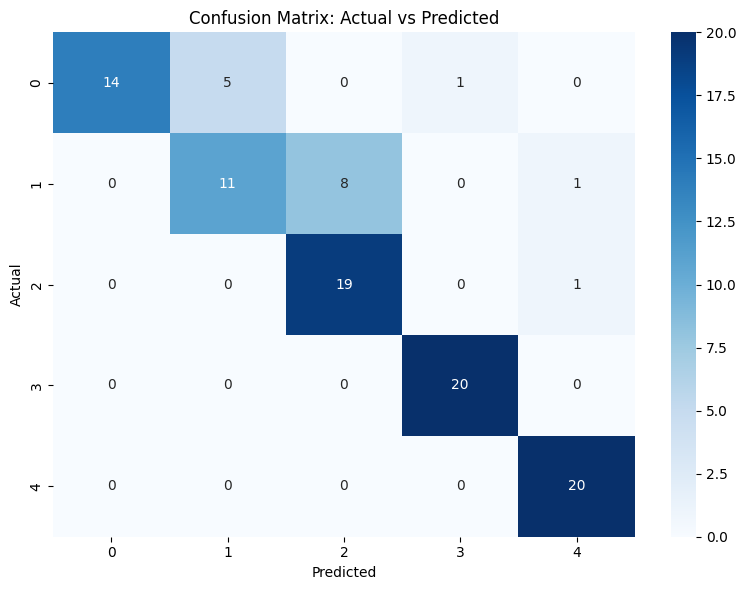

In [41]:
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

optimized_evaluator = ProductSentimentPolarity()
optimized_evaluator.load("./results/product_sentiment_polarity_openai_experiment_gpt-3.5-turbo_cunning-private-pronghorn_train_82.67_dev_84.0_manually_adjusted.json")
optimized_evaluator(output=dev_example.output)

evaluate = Evaluate(
    devset=devset,
    metric=sentiment_matches,
    num_threads=4,
    display_progress=True,
    display_table=0,
    return_outputs=True,
)
score, results = evaluate(optimized_evaluator)  # type: ignore

sentiment_map = {
    "skipped": 4,
    "very_positive": 3,
    "subtly_positive": 2,
    "subtly_negative": 1,
    "very_negative": 0,
}

y = [sentiment_map[example[0].sentiment] for example in results]
y_pred = [sentiment_map[example[1].sentiment] for example in results]


conf_matrix = confusion_matrix(y, y_pred)

# Plotting confusion matrices
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix: Actual vs Predicted")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

plt.tight_layout()

In [36]:
for example, example_pred, match in results:
    if not match:
        print(example.output, "\n", example.sentiment, "\nvs\n", example_pred)
        print("")

The Pixel 8’s interface is quite user-friendly, particularly for first-time Android users, thanks to its clean and intuitive design influenced by Google's Material You. While it is streamlined and relatively easy to navigate, it might not be as polished or feature-rich as some higher-end competitors like Samsung's One UI. Still, it's a solid and straightforward choice for beginners. 
 subtly_negative 
vs
 Prediction(
    reasoning="The output compares the Pixel 8's interface to competitors like Samsung's One UI, noting that it may not be as polished or feature-rich. However, it acknowledges the user-friendly nature of the interface and its suitability for first-time Android users, ultimately considering it a solid choice.",
    sentiment='subtly_positive'
)

Both the iPhone 15 and iPhone 15 Pro support fast charging, but the Pro models typically have a slight edge due to optimized hardware and software integration. While both can reach approximately 50% charge in around 30 minutes with

**Accuracy MIPRO** - 72.84%

# 3. Conclusions

### Results and Comparison
The baseline accuracy of gpt-3.5-turbo is 43.8%.

**DSPy Optimizers Leaderboard**
1. MIPRO - 72.84%
2. BootstrapFewShotWithOptuna - 71.6%
3. BootstrapFewShot - 60.49%
4. BootstrapFewShotWithRandomSearch - 59.26%
5. KNNFewShot - 50.62%
6. COPRO - 43.21%

Most of the optimizers have shown moderate to significant improvement compared to the baseline model accuracy.

### Future Improvements for the Notebook
Add confusion matrices for each evaluator to see which categories are most often mislabeled.

### Notes and Discussion
General notes about the experiment:
1. For MIPRO and COPRO optimizations, the given training dataset was too small. Better results could potentially be achieved with more data and a bigger budget available.
2. The quality of the whole dataset is not verified as it was artificially created by an LLM. Although it fully suffices for the primary goal of this experiment - to verify if DSPy optimizers can actually improve the results. Experiments with human-LLM interaction datasets would be interesting to explore in future trials. Additionally, experiments with human-made answers should be explored in the next experiments.
3. For simplicity, the task was defined as a basic classification, and the requirement for "reasoning" or "positive_points" and "negative_points" was lifted. It is worth exploring further how priming would affect the final decision of an LLM.
4. As the documentation of the DSPy library does not cover all the details, not all of the optimizers were used with optimal input parameters. The selection of most input parameters was based on the examples given in the [DSPy Cheatsheet](https://dspy-docs.vercel.app/docs/cheatsheet). We believe that certain optimizers could show better accuracy if the input parameters were chosen more thoroughly.